# Data Analysis Task

## Background

*Event logging* (EL) is used to track a variety of performance and usage metrics to help on the decision making process. Specifically, the most used metrics are:

- *clickthrough rate*: the proportion of search sessions where the user clicked on one of the results displayed
- *zero results rate*: the proportion of searches that yielded 0 results

and other metrics outside the scope of this task. EL uses JavaScript to asynchronously send messages (events) to the servers when the user has performed specific actions. In this task, you will analyze a subset of our event logs.

## Task

You must create a **reproducible report**\* answering the following questions:

1. What is the daily overall clickthrough rate? How does it vary between the groups?
2. Which results do people tend to try first? How does it change day-to-day?
3. What is the daily overall zero results rate? How does it vary between the groups?
4. Let *session length* be approximately the time between the first event and the last event in a session. Choose a variable from the dataset and describe its relationship to session length. Visualize the relationship.
5. Summarize your findings in an *executive summary*.

## Data

Desktop users are randomly sampled to be anonymously tracked by this schema which uses a "I'm alive" pinging system that it is used to estimate how long users stay on the pages they visit. The dataset contains just a little more than a week of EL data.

| Column          | Value   | Description                                                                       |
|:----------------|:--------|:----------------------------------------------------------------------------------|
| uuid            | string  | Universally unique identifier (UUID) for backend event handling.|
| timestamp       | integer | The date and time (UTC) of the event, formatted as YYYYMMDDhhmmss.                |
| session_id      | string  | A unique ID identifying individual sessions.                                      |
| group           | string  | A label ("a" or "b").                               |
| action          | string  | Identifies in which the event was created. See below.                             |
| checkin         | integer | How many seconds the page has been open for.                                      |
| page_id         | string  | A unique identifier for correlating page visits and check-ins.                    |
| n_results       | integer | Number of hits returned to the user. Only shown for searchResultPage events.      |
| result_position | integer | The position of the visited page's link on the search engine results page (SERP). |

The following are possible values for an event's action field:

- **searchResultPage**: when a new search is performed and the user is shown a SERP.
- **visitPage**: when the user clicks a link in the results.
- **checkin**: when the user has remained on the page for a pre-specified amount of time.

### Example Session

|uuid                             |      timestamp|session_id       |group |action           | checkin|page_id          | n_results| result_position|
|:--------------------------------|:--------------|:----------------|:-----|:----------------|-------:|:----------------|---------:|---------------:|
|4f699f344515554a9371fe4ecb5b9ebc | 20160305195246|001e61b5477f5efc |b     |searchResultPage |      NA|1b341d0ab80eb77e |         7|              NA|
|759d1dc9966353c2a36846a61125f286 | 20160305195302|001e61b5477f5efc |b     |visitPage        |      NA|5a6a1f75124cbf03 |        NA|               1|
|77efd5a00a5053c4a713fbe5a48dbac4 | 20160305195312|001e61b5477f5efc |b     |checkin          |      10|5a6a1f75124cbf03 |        NA|               1|
|42420284ad895ec4bcb1f000b949dd5e | 20160305195322|001e61b5477f5efc |b     |checkin          |      20|5a6a1f75124cbf03 |        NA|               1|
|8ffd82c27a355a56882b5860993bd308 | 20160305195332|001e61b5477f5efc |b     |checkin          |      30|5a6a1f75124cbf03 |        NA|               1|
|2988d11968b25b29add3a851bec2fe02 | 20160305195342|001e61b5477f5efc |b     |checkin          |      40|5a6a1f75124cbf03 |        NA|               1|

This user's search query returned 7 results, they clicked on the first result, and stayed on the page between 40 and 50 seconds. (The next check-in would have happened at 50s.)

Task 100% inspired by this one -> https://github.com/wikimedia-research/Discovery-Hiring-Analyst-2016





In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# style of plots
sns.set_style("darkgrid")

In [2]:
# data loading
df = pd.read_csv('events_log.csv')

In [3]:
# dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400165 entries, 0 to 400164
Data columns (total 9 columns):
uuid               400165 non-null object
timestamp          400165 non-null float64
session_id         400165 non-null object
group              400165 non-null object
action             400165 non-null object
checkin            223824 non-null float64
page_id            400165 non-null object
n_results          136234 non-null float64
result_position    230482 non-null float64
dtypes: float64(4), object(5)
memory usage: 27.5+ MB


In [4]:
df.head()

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position
0,00000736167c507e8ec225bd9e71f9e5,2.016030e+13,78245c2c3fba013a,b,searchResultPage,NaN,cbeb66d1bc1f1bc2,5.0,NaN
1,00000c69fe345268935463abbfa5d5b3,2.016031e+13,c559c3be98dca8a4,a,searchResultPage,NaN,eb658e8722aad674,10.0,NaN
2,00003bfdab715ee59077a3670331b787,2.016030e+13,760bf89817ce4b08,a,checkin,30.0,f99a9fc1f7fdd21e,NaN,NaN
3,0000465cd7c35ad2bdeafec953e08c1a,2.016030e+13,fb905603d31b2071,a,checkin,60.0,e5626962a6939a75,NaN,10.0
4,000050cbb4ef5b42b16c4d2cf69e6358,2.016030e+13,c2bf5e5172a892dc,a,checkin,30.0,787dd6a4c371cbf9,NaN,NaN


In [5]:
# Convert timestamp from float to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H%M%S')

# Create new column with only date from timestamp
df['date'] = df['timestamp'].apply(lambda var: var.date())
df.head()

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,date
0,00000736167c507e8ec225bd9e71f9e5,2016-03-01 10:38:42,78245c2c3fba013a,b,searchResultPage,NaN,cbeb66d1bc1f1bc2,5.0,NaN,2016-03-01
1,00000c69fe345268935463abbfa5d5b3,2016-03-07 00:52:26,c559c3be98dca8a4,a,searchResultPage,NaN,eb658e8722aad674,10.0,NaN,2016-03-07
2,00003bfdab715ee59077a3670331b787,2016-03-02 14:53:05,760bf89817ce4b08,a,checkin,30.0,f99a9fc1f7fdd21e,NaN,NaN,2016-03-02
3,0000465cd7c35ad2bdeafec953e08c1a,2016-03-02 22:27:01,fb905603d31b2071,a,checkin,60.0,e5626962a6939a75,NaN,10.0,2016-03-02
4,000050cbb4ef5b42b16c4d2cf69e6358,2016-03-02 09:50:23,c2bf5e5172a892dc,a,checkin,30.0,787dd6a4c371cbf9,NaN,NaN,2016-03-02


In [6]:
# Number of data for different dates
df['date'].value_counts()

2016-03-03    60644
2016-03-02    60322
2016-03-01    59324
2016-03-07    52558
2016-03-04    45746
2016-03-08    44129
2016-03-06    41200
2016-03-05    36242
Name: date, dtype: int64

Text(0.5, 1.0, 'Total number of clicks')

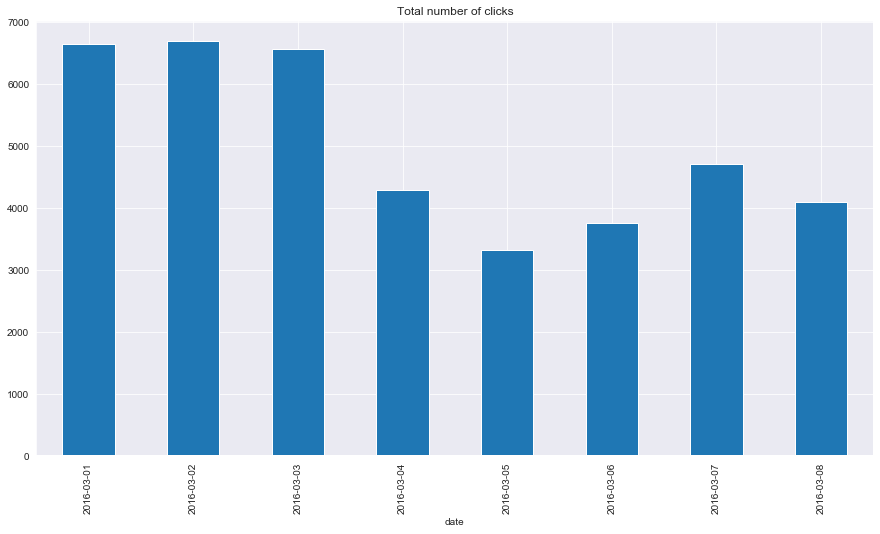

In [7]:
# Total number of clicks by dates
df[df['action'] == 'visitPage'].groupby('date')['page_id'].count().plot(figsize=(15, 8), kind='bar')
plt.title('Total number of clicks')

Text(0.5, 1.0, 'Total number of clicks')

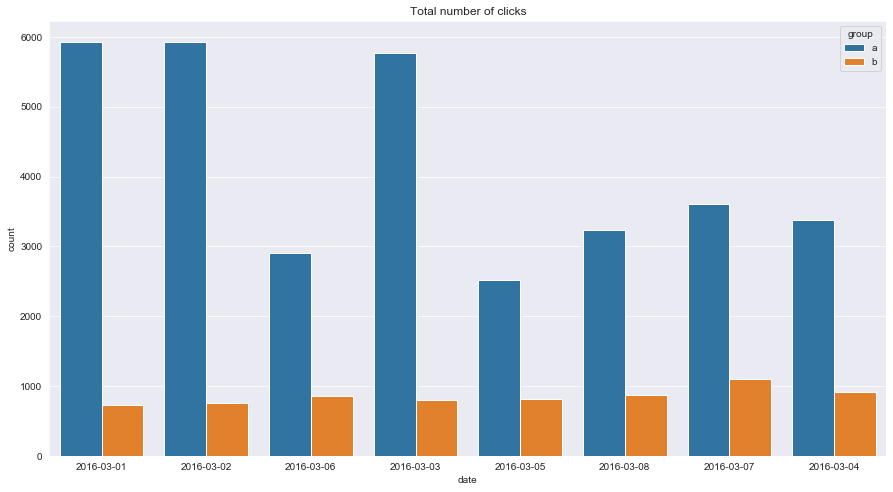

In [8]:
# Total number of clicks by dates, for different groups
visitPageGroup = df[df['action'] == 'visitPage']

plt.figure(figsize=(15, 8))
sns.countplot(x='date', data=visitPageGroup, hue='group')
plt.title('Total number of clicks')

In [9]:
# create new column day of week
df['day of week'] = df['timestamp'].apply(lambda var: var.weekday())

# change values in new column into strings
dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df['day of week'] = df['day of week'].map(dmap)
df.head()

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,date,day of week
0,00000736167c507e8ec225bd9e71f9e5,2016-03-01 10:38:42,78245c2c3fba013a,b,searchResultPage,NaN,cbeb66d1bc1f1bc2,5.0,NaN,2016-03-01,Tue
1,00000c69fe345268935463abbfa5d5b3,2016-03-07 00:52:26,c559c3be98dca8a4,a,searchResultPage,NaN,eb658e8722aad674,10.0,NaN,2016-03-07,Mon
2,00003bfdab715ee59077a3670331b787,2016-03-02 14:53:05,760bf89817ce4b08,a,checkin,30.0,f99a9fc1f7fdd21e,NaN,NaN,2016-03-02,Wed
3,0000465cd7c35ad2bdeafec953e08c1a,2016-03-02 22:27:01,fb905603d31b2071,a,checkin,60.0,e5626962a6939a75,NaN,10.0,2016-03-02,Wed
4,000050cbb4ef5b42b16c4d2cf69e6358,2016-03-02 09:50:23,c2bf5e5172a892dc,a,checkin,30.0,787dd6a4c371cbf9,NaN,NaN,2016-03-02,Wed


Text(0.5, 1.0, 'Total number of clicks')

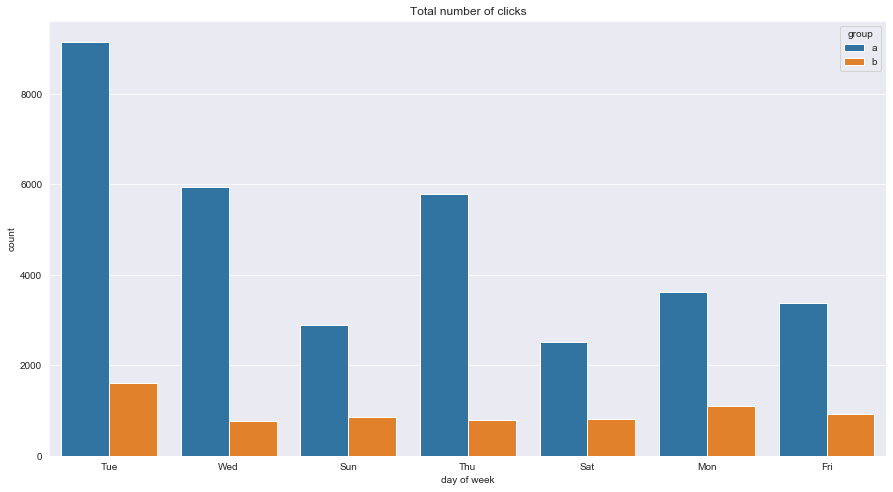

In [10]:
# Total number of clicks by days (NOT DATES), for different groups
visitPageGroup = df[df['action'] == 'visitPage']

plt.figure(figsize=(15, 8))
sns.countplot(x='day of week', data=visitPageGroup, hue='group')
plt.title('Total number of clicks')

Total clickthrough rate
by definition: (clickSessionNum / sessionNum) * 100%

In [11]:
# number of sessions (without checkins, because their already included in visitPage action)
sessionNum = df[df['action'] != 'checkin']['session_id'].nunique()
sessionNum
#allSessions = df[df['action'] != 'checkin'].groupby('session_id').count()['page_id']
#allSessions
#len(allSessions)

68013

In [12]:
# number of sessions with click on one of search results
clickSessions = df[df['action'] == 'visitPage'].groupby('session_id').count()['page_id']
clickSessionNum = len(clickSessions)
clickSessionNum

26452

In [13]:
# DEF 1. total clickthrough rate (by definition: (clickSessionNum / sessionNum) * 100% )
clickthroughtRate1 = (clickSessionNum / sessionNum) * 100
print('total clickthrought rate by first definition = {} %'.format(clickthroughtRate1))

total clickthrought rate by first definition = 38.8925646567568 %


Total clickthrough rate by definition: (clickSessionNum / sessionNum) * 100%

For each of dates

In [14]:
# DEF 1. total clickthrough rate (by definition: (clickSessionNum / sessionNum) * 100% ) for each date
# number of sessions for each day
sessionsByDate = df[df['action'] != 'checkin'].groupby(['date'])['session_id'].nunique()
sessionsByDate

date
2016-03-01    9252
2016-03-02    9206
2016-03-03    9350
2016-03-04    8248
2016-03-05    6733
2016-03-06    7643
2016-03-07    9541
2016-03-08    8084
Name: session_id, dtype: int64

In [15]:
clickSessionsByDate = df[df['action'] == 'visitPage'].groupby('date')['session_id'].nunique()
clickSessionsByDate

date
2016-03-01    3524
2016-03-02    3602
2016-03-03    3626
2016-03-04    3287
2016-03-05    2573
2016-03-06    2968
2016-03-07    3747
2016-03-08    3140
Name: session_id, dtype: int64

Text(0.5, 1.0, 'Clickthrough rate by dates')

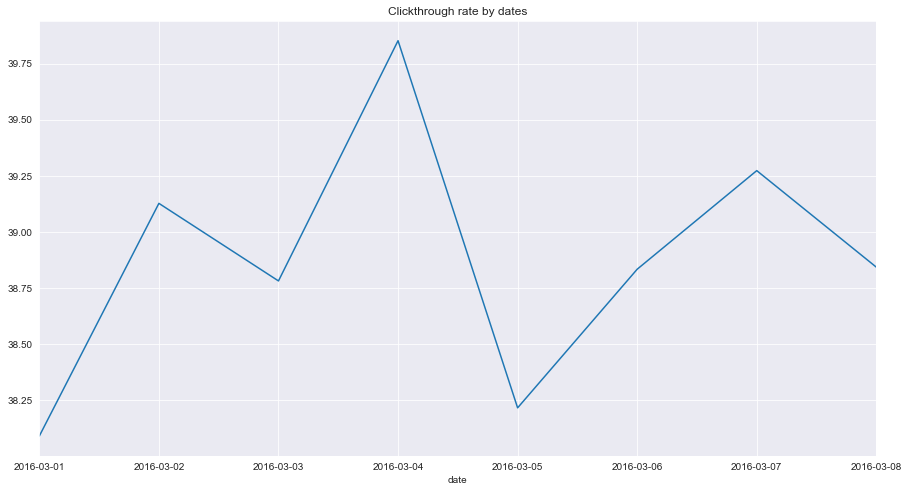

In [16]:
ctrDates1 = ((clickSessionsByDate / sessionsByDate) * 100).plot(figsize=(15, 8))
plt.title('Clickthrough rate by dates')

Total clickthrough rate by definition: (clickSessionNum / sessionNum) * 100%

For each of dates and groups

In [17]:
# mozda i == 'searchResultPage'
sessionsByDateGroups = df[df['action'] != 'checkin'].groupby(['date', 'group'])['session_id'].nunique()
sessionsByDateGroups

date        group
2016-03-01  a        4210
            b        5042
2016-03-02  a        4219
            b        4987
2016-03-03  a        4205
            b        5145
2016-03-04  a        3513
            b        4735
2016-03-05  a        2731
            b        4002
2016-03-06  a        3140
            b        4503
2016-03-07  a        4029
            b        5512
2016-03-08  a        3420
            b        4664
Name: session_id, dtype: int64

In [18]:
sessionsClickByDateGroups = df[df['action'] == 'visitPage'].groupby(['date', 'group'])['session_id'].nunique()
sessionsClickByDateGroups

date        group
2016-03-01  a        2825
            b         699
2016-03-02  a        2877
            b         725
2016-03-03  a        2844
            b         782
2016-03-04  a        2374
            b         913
2016-03-05  a        1764
            b         809
2016-03-06  a        2114
            b         854
2016-03-07  a        2648
            b        1099
2016-03-08  a        2275
            b         865
Name: session_id, dtype: int64

Text(0.5, 1.0, 'Clickthrough rate by dates for both groups')

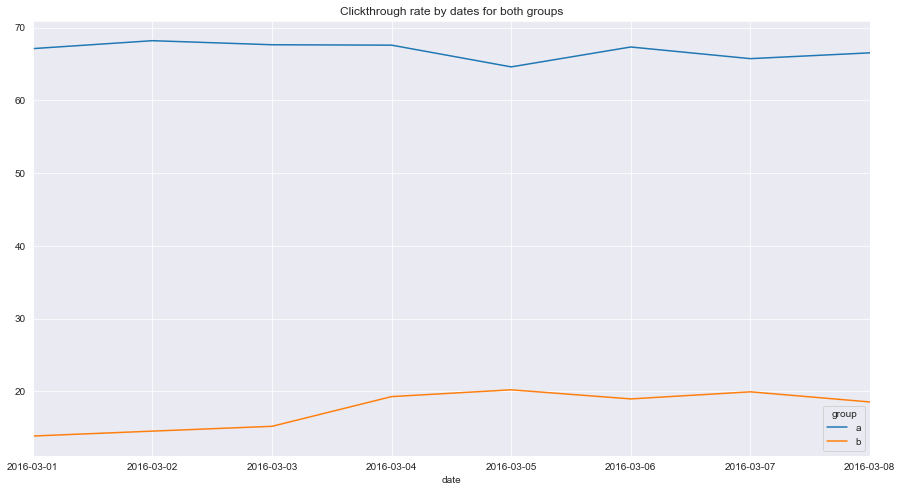

In [19]:
ctrDatesGroups1 = (sessionsClickByDateGroups / sessionsByDateGroups) * 100
ctrDatesGroups1.unstack().plot(figsize=(15, 8))
plt.title('Clickthrough rate by dates for both groups')

Clickthrough rate by definition: ctr = num of click / num of shown results (on session level)

Definition from Skype

In [20]:
# number of search results for each different session
numOfResults = df.groupby('session_id')['n_results'].sum()
numOfResults

session_id
0000cbcb67c19c45     20.0
0001382e027b2ea4     18.0
0001e8bb90445cb2     20.0
000216cf18ae1ab1    120.0
000527f711d50dfc      1.0
00064fe774048046      1.0
00071a2cf97168df     20.0
0007582fe23d51e6      0.0
0007b7f6b575feb6     20.0
00086b6ff8156928      0.0
000936ae06d62383     20.0
000951bf5fe30840     20.0
00099d10c3e9149a      3.0
000b113f9abde96a     20.0
000b72561100b509     20.0
000eb0a149f6232c      0.0
000f17bb91b8d6dc     20.0
000fb60e9dab4303     42.0
00106ab7f5dba3db    100.0
00107af22eb9dc3a     20.0
00110030e5582a05     40.0
001113537e4f8a9f      0.0
0011d89c413e9adb     40.0
00128afbdfb1e2a5      6.0
00131dfc3cd00a65     40.0
0013922a4ed4df0a     20.0
0013974d3a981c99      0.0
00139b84719e8062      3.0
0014bd91520b25f4      9.0
0014fac7fd3e71e2     20.0
                    ...  
ffe002036e370b06    140.0
ffe1a14d4565573d     20.0
ffe1be6af4a9b8bb      6.0
ffe23dcfbc85e73d     20.0
ffe454e0e2dc801d      0.0
ffe78a0ddf066d97     13.0
ffe7e6f264d596f5     20.0
f

In [46]:
# number of clicks (visited pages) for each different session
numOfClicks = df[df['action'] == 'visitPage'].groupby('session_id')['page_id'].count()
numOfClicks

session_id
0001382e027b2ea4    1
0001e8bb90445cb2    1
00064fe774048046    1
0007b7f6b575feb6    3
000b72561100b509    1
000f17bb91b8d6dc    1
000fb60e9dab4303    1
00131dfc3cd00a65    1
0014bd91520b25f4    1
0017941fc481e3cd    1
001a5d781a77e163    1
001b3ab86a341cb8    1
001e2d0e159172d2    1
001e61b5477f5efc    1
0021bdc79443f16b    1
00224c4200d5a2f1    1
0024c4506bf92e1c    2
00277db385057323    1
002856cd6d1f2fd8    1
0029420a5f8c7d90    1
002b97995ca9ce77    2
002d123e0605ad64    1
003037c8d3c3fe94    1
00317ffe60c93021    3
0031a92ff6c1d7a6    1
0033cbfcfa745cf9    1
0034a5ad56ece776    1
0036c92860f1e6e3    1
00376681bebc19f5    1
0038e2d15bd5859a    1
                   ..
ffbe76f2d777029a    1
ffc1fa66ded4bbc7    1
ffc2a8bd07506206    1
ffc506c2f7d24b32    1
ffc7058c6769e3ac    2
ffc8a4206d7272ee    1
ffc8e9affd1f6770    2
ffcdebd4713829d3    2
ffce5c81ae5782cc    1
ffd1aaf1e0fbb88e    1
ffd85369e0e6d8a7    1
ffd88039c4b94be2    2
ffda8f3cff8f953c    1
ffdb4d6bd1d6449e    1

(1, 100)

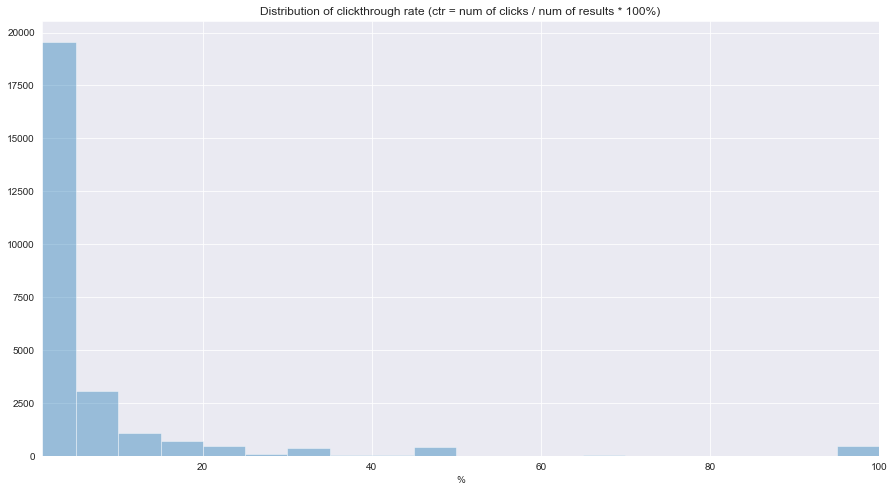

In [49]:
# ctr = num of click / num of shown results (on session level)
ctr2 = numOfClicks[numOfClicks > 0] / numOfResults[numOfResults > 0] * 100
ctr2 = ctr2[ctr2 <= 100]

# distribution plot of results
plt.figure(figsize=(15, 8))
sns.distplot(ctr2, kde=False, bins=20)
plt.title('Distribution of clickthrough rate (ctr = num of clicks / num of results * 100%)')
plt.xlabel('%')
plt.xlim(1, 100)

# here we can see that people tend to open just a few link per session (most of the time just one link)

3. What is the daily overall zero results rate? How does it vary between the groups?

def. => zero results rate = zero results sessions / all search sessions

In [23]:
# zero results rate = (zero results sessions / all sessions) * 100
allSearchSessions = df[df['action'] == 'searchResultPage'].groupby(['date', 'group']).count()['page_id']
allSearchSessions

date        group
2016-03-01  a        12582
            b         5792
2016-03-02  a        13209
            b         5693
2016-03-03  a        13280
            b         5879
2016-03-04  a        11298
            b         5377
2016-03-05  a         8612
            b         4592
2016-03-06  a         9469
            b         5143
2016-03-07  a        12699
            b         6312
2016-03-08  a        10907
            b         5390
Name: page_id, dtype: int64

In [24]:
zeroResultsSessions = df[df['n_results'] == 0].groupby(['date', 'group']).count()['page_id']
zeroResultsSessions

date        group
2016-03-01  a        2350
            b        1097
2016-03-02  a        2524
            b        1065
2016-03-03  a        2371
            b        1072
2016-03-04  a        2068
            b         947
2016-03-05  a        1535
            b         907
2016-03-06  a        1599
            b         975
2016-03-07  a        2316
            b        1144
2016-03-08  a        2139
            b        1018
Name: page_id, dtype: int64

In [25]:
zrr = (zeroResultsSessions / allSearchSessions) * 100
zrr

date        group
2016-03-01  a        18.677476
            b        18.939917
2016-03-02  a        19.108184
            b        18.707184
2016-03-03  a        17.853916
            b        18.234394
2016-03-04  a        18.304125
            b        17.612051
2016-03-05  a        17.823967
            b        19.751742
2016-03-06  a        16.886683
            b        18.957807
2016-03-07  a        18.237657
            b        18.124208
2016-03-08  a        19.611259
            b        18.886827
Name: page_id, dtype: float64

Text(0, 0.5, '%')

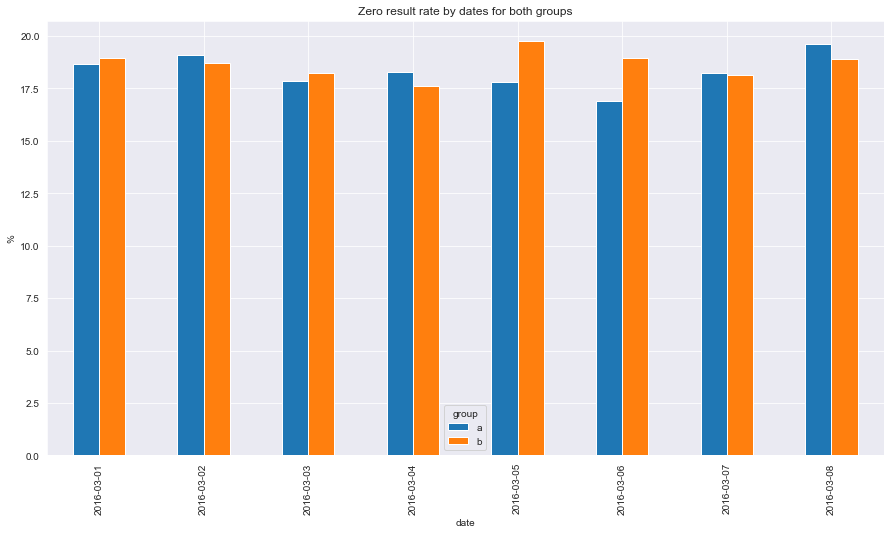

In [99]:
zrr.unstack().plot.bar(figsize=(15, 8))
plt.title('Zero result rate by dates for both groups')
plt.ylabel('%')
#zrr.unstack().plot()

2. Which results do people tend to try first? How does it change day-to-day?

Text(0.5, 1.0, 'Relation between result position and number of clicks')

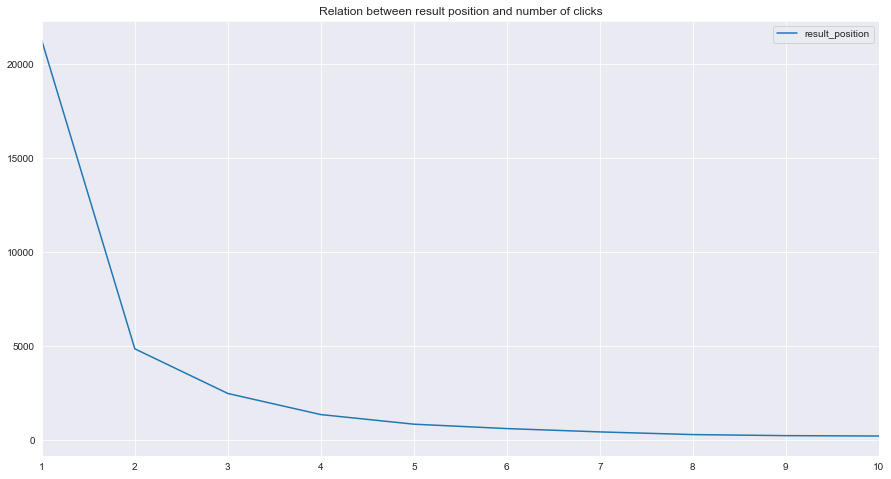

In [27]:
#value_count() i distribucija vrednosti result_position
resPositionDistribution = df[df['action'] == 'visitPage']['result_position'].value_counts()
dfRPD = pd.DataFrame(index=resPositionDistribution.index, data=resPositionDistribution)
dfRPD.nlargest(10, 'result_position').plot(figsize=(15, 8))
plt.title('Relation between result position and number of clicks')

Text(0, 0.5, 'Number of clicks')

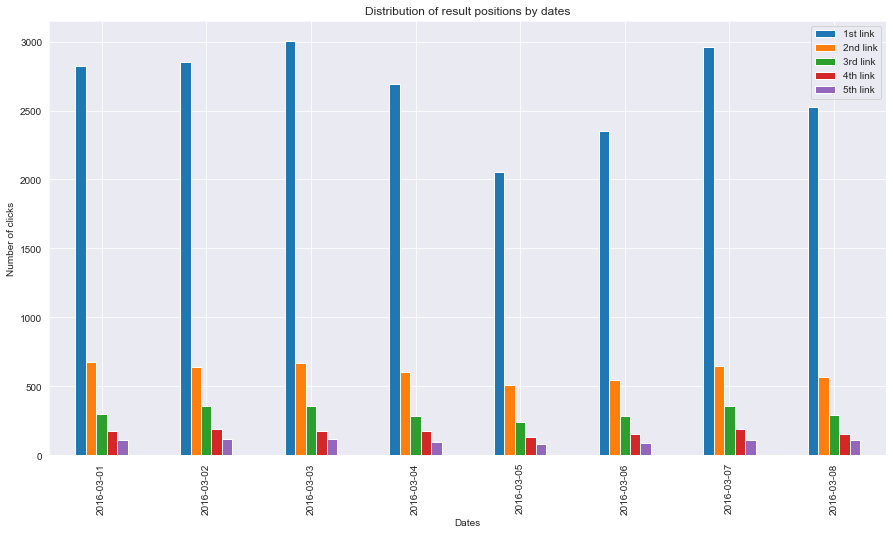

In [28]:
# distribution of result position by dates
tempRPD = df[df['action'] == 'visitPage'].groupby('date')['result_position'].apply(lambda var: var.value_counts().nlargest(5))
dfDateRPD = pd.DataFrame(index=tempRPD.index, data=tempRPD).unstack()

# plotting results
labels = ['1st link', '2nd link', '3rd link', '4th link', '5th link']
ax = dfDateRPD.plot(kind='bar', figsize=(15, 8)).legend(labels)
plt.title('Distribution of result positions by dates')
plt.xlabel('Dates')
plt.ylabel('Number of clicks')

4. Let session length be approximately the time between the first event and the last event in a session. Choose a variable from the dataset and describe its relationship to session length. Visualize the relationship.

In [29]:
# start of each session
sessionStart = df.groupby('session_id').apply(lambda var: var['timestamp'].min())
sessionStart

session_id
0000cbcb67c19c45   2016-03-03 15:20:45
0001382e027b2ea4   2016-03-07 08:49:55
0001e8bb90445cb2   2016-03-05 09:24:15
000216cf18ae1ab1   2016-03-08 16:19:46
000527f711d50dfc   2016-03-08 05:33:00
00064fe774048046   2016-03-05 07:42:04
00071a2cf97168df   2016-03-07 14:50:35
0007582fe23d51e6   2016-03-02 00:13:05
0007b7f6b575feb6   2016-03-03 16:56:29
00086b6ff8156928   2016-03-07 05:29:01
000936ae06d62383   2016-03-01 12:36:54
000951bf5fe30840   2016-03-04 12:10:35
00099d10c3e9149a   2016-03-03 05:24:12
000b113f9abde96a   2016-03-07 04:52:26
000b72561100b509   2016-03-02 17:25:17
000eb0a149f6232c   2016-03-05 16:48:14
000f17bb91b8d6dc   2016-03-05 08:52:32
000fb60e9dab4303   2016-03-02 21:26:06
00106ab7f5dba3db   2016-03-02 16:19:22
00107af22eb9dc3a   2016-03-07 22:44:44
00110030e5582a05   2016-03-02 08:33:25
001113537e4f8a9f   2016-03-02 18:36:52
0011d89c413e9adb   2016-03-04 16:45:30
00128afbdfb1e2a5   2016-03-06 08:21:23
00131dfc3cd00a65   2016-03-08 01:16:52
0013922a4ed4df

In [30]:
# stop of each session
sessionStop = df.groupby('session_id').apply(lambda var: var['timestamp'].max())
sessionStop

session_id
0000cbcb67c19c45   2016-03-03 15:20:45
0001382e027b2ea4   2016-03-07 08:54:58
0001e8bb90445cb2   2016-03-05 09:31:30
000216cf18ae1ab1   2016-03-08 16:20:44
000527f711d50dfc   2016-03-08 05:33:00
00064fe774048046   2016-03-05 07:42:47
00071a2cf97168df   2016-03-07 14:50:35
0007582fe23d51e6   2016-03-02 00:13:05
0007b7f6b575feb6   2016-03-03 17:02:08
00086b6ff8156928   2016-03-07 05:29:01
000936ae06d62383   2016-03-01 12:36:54
000951bf5fe30840   2016-03-04 12:10:35
00099d10c3e9149a   2016-03-03 05:24:12
000b113f9abde96a   2016-03-07 04:52:26
000b72561100b509   2016-03-02 17:32:41
000eb0a149f6232c   2016-03-05 16:48:14
000f17bb91b8d6dc   2016-03-05 08:54:24
000fb60e9dab4303   2016-03-02 21:29:39
00106ab7f5dba3db   2016-03-02 16:22:05
00107af22eb9dc3a   2016-03-07 22:44:44
00110030e5582a05   2016-03-02 08:33:28
001113537e4f8a9f   2016-03-02 18:36:52
0011d89c413e9adb   2016-03-04 16:46:26
00128afbdfb1e2a5   2016-03-06 08:21:23
00131dfc3cd00a65   2016-03-08 01:24:15
0013922a4ed4df

In [41]:
# sessionLenght = sessionStop - sessionStart
sessionLength = sessionStop - sessionStart
sessionLength = sessionLength.apply(lambda var: var.total_seconds())
sessionLength = list(sessionLength)

In [143]:
# max checkin for each session and page_id
totalCheckins = df.groupby(['session_id', 'page_id']).apply(lambda var: var['checkin'].max())
totalCheckins = totalCheckins.groupby('session_id').sum()
totalCheckins = totalCheckins.fillna(0)
totalCheckins = list(totalCheckins)

In [74]:
# number of results for each session
resultNums = df.groupby('session_id')['n_results'].sum()
resultNums = list(resultNums)

In [117]:
# create new dataframe with two columns: total session length and visit page length
dfLengths = pd.DataFrame(list(zip(sessionLength, totalCheckins, resultNums)), columns=['session length', 'visit page length', 'number of results'])
dfLengths.head()

,session length,visit page length,number of results
0,0.0,0.0,20.0
1,303.0,300.0,18.0
2,435.0,420.0,20.0
3,58.0,0.0,120.0
4,0.0,0.0,1.0


In [147]:
# session length, visit page length and number of results, without session with 0 duration
notZeroLengths = pd.DataFrame(dfLengths[dfLengths['session length'] > 0])
notZeroLengths.head()

,session length,visit page length,number of results
1,303.0,300.0,18.0
2,435.0,420.0,20.0
3,58.0,0.0,120.0
5,43.0,10.0,1.0
8,339.0,300.0,20.0


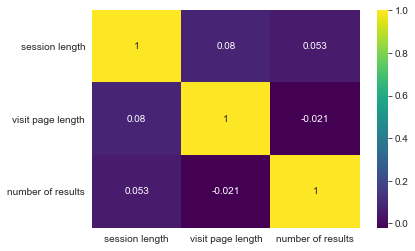

In [148]:
# correlation heatmap
sns.heatmap(notZeroLengths.corr(), annot=True, cmap='viridis')

In [160]:
# add column for proportion between session length and visit page length
temp = notZeroLengths['visit page length'] / notZeroLengths['session length'] * 100
notZeroLengths['proportion'] = temp
notZeroLengths

,session length,visit page length,number of results,proportion
1,303.0,300.0,18.0,99.009901
2,435.0,420.0,20.0,96.551724
3,58.0,0.0,120.0,0.000000
5,43.0,10.0,1.0,23.255814
8,339.0,300.0,20.0,88.495575
14,444.0,420.0,20.0,94.594595
16,112.0,90.0,20.0,80.357143
17,213.0,0.0,42.0,0.000000
18,163.0,0.0,100.0,0.000000
20,3.0,0.0,40.0,0.000000


Text(0, 0.5, 'Number of sessions')

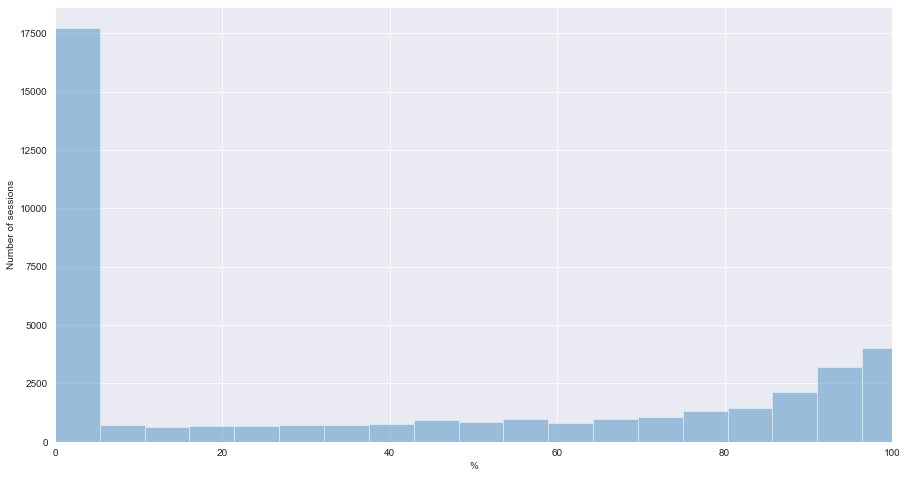

In [167]:
# plot distribution of proportion between duration of entire session and duration of link visits (search results links)
plt.figure(figsize=(15, 8))
sns.distplot(notZeroLengths['proportion'], kde=False, bins=70)
plt.xlim(0, 100)
plt.xlabel('%')
plt.ylabel('Number of sessions')

# here we can see that there are a lot of sessions with 0% <=> 0 seconds spent on visited pages (there are 0 visited pages)
# also we can see that there are a lot of session with between 90-100% <=> 
# almost all of session duration is spent on visited pages 

Text(0, 0.5, 'Number of sessions')

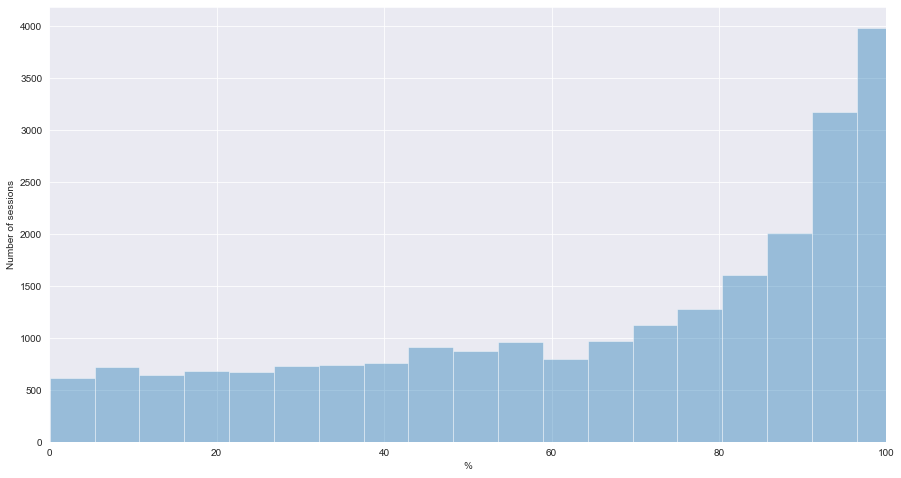

In [169]:
# plot distribution of proportion between duration of entire session and duration of link visits (search results links)
# 0 values of visited pages length are excluded!
plt.figure(figsize=(15, 8))
sns.distplot(notZeroLengths[notZeroLengths['proportion'] > 0]['proportion'], kde=False, bins=70)
plt.xlim(0, 100)
plt.xlabel('%')
plt.ylabel('Number of sessions')

# this plot shows similar distributuion as previous, but 0 values are excluded
# the number of sessions with high precentage of time spent on "visit page links" (search result page links) is clearer here,
# because 0 values are excluded

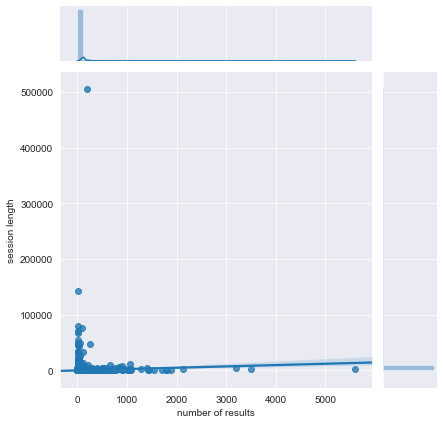

In [121]:
sns.jointplot(x='number of results', y='session length', data=notZeroLengths, kind='reg')

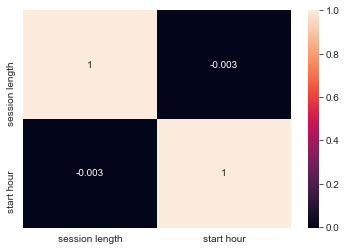

In [127]:
# session length and hour of session start
# check if there is any correlation between time when session is started (hours) and duration of session
startHours = sessionStart.apply(lambda var: var.hour)
dfStartLength = pd.DataFrame(list(zip(sessionLength, startHours)), columns=['session length', 'start hour'])
sns.heatmap(dfStartLength[dfStartLength['session length'] > 0].corr(), annot=True)

# there isn't much of correlation between hour when session is started and duration of session

Series([], dtype: float64)